In [ ]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Gin Rummy

## Imports

In [1]:
#-------------------------------------------------------------------------------
# The following code was originally written by Todd Neller in Java.
# It was translated into Python by Anthony Hein.
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# A class for modeling a game of Gin Rummy
# @author Todd W. Neller
# @version 1.0
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Copyright (C) 2020 Todd Neller
#
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 2
# of the License, or (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Information about the GNU General Public License is available online at:
#   http://www.gnu.org/licenses/
# To receive a copy of the GNU General Public License, write to the Free
# Software Foundation, Inc., 59 Temple Place - Suite 330, Boston, MA
# 02111-1307, USA.
#-------------------------------------------------------------------------------

%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import random
import time
from Deck import Deck
from GinRummyUtil import GinRummyUtil
from SimpleGinRummyPlayer import SimpleGinRummyPlayer
from OpponentHandEstimationPlayer import OpponentHandEstimationPlayer

%cd /content/drive/My Drive/Colab Notebooks/Thesis
#-------------------------------------------------------------------------------
# TRACKING
import numpy as np
# tracking_states = []
# tracking_states2 = []
# tracking_hands = []
# tracking_handsO = []
curr_hand = []
knock = []
winloss = []

def one_hot(cards):
    ret = np.zeros(52)
    for card in cards:
        ret[card.getId()] = 1
    return ret

def un_one_hot(arr):
    rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
    suitNames = ["C", "H", "S", "D"]
    ret = []
    for i in range(len(arr)):
        if arr[i] != 0:
            ret.append(rankNames[i%13] + suitNames[i//13])
    return ret
#-------------------------------------------------------------------------------

/content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
/content/drive/My Drive/Colab Notebooks/Thesis


## Class Definition/Data Part

In [ ]:
class GinRummyGame:

    # Hand size (before and after turn). After draw and before discard there is one extra card.
    HAND_SIZE = 10;

    # Whether or not to print information during game play
    playVerbose = False;

    # Two Gin Rummy players numbered according to their array index.
    players = [];

    # Set whether or not there is to be printed output during gameplay.
    def setPlayVerbose(playVerbose):
        GinRummyGame.playVerbose = playVerbose

    # Create a GinRummyGame with two given players
    def __init__(self, player0, player1):
        GinRummyGame.players.extend([player0, player1])

    # Play a game of Gin Rummy and return the winning player number 0 or 1.
    # @return the winning player number 0 or 1
    def play(self):
        scores = [0, 0]
        hands = []
        hands.extend([[], []])

        startingPlayer = random.randrange(2);

        # while game not over
        while scores[0] < GinRummyUtil.GOAL_SCORE and scores[1] < GinRummyUtil.GOAL_SCORE:

            currentPlayer = startingPlayer
            opponent = (1 if currentPlayer == 0 else 0)

            # get shuffled deck and deal cards
            deck = Deck.getShuffle(random.randrange(10 ** 8))
            hands[0] = []
            hands[1] = []
            for i in range(2 * GinRummyGame.HAND_SIZE):
                hands[i % 2] += [deck.pop()]
            for i in range(2):
                GinRummyGame.players[i].startGame(i, startingPlayer, hands[i]);
                if GinRummyGame.playVerbose:
                    print("Player %d is dealt %s.\n" % (i, hands[i]))
            if GinRummyGame.playVerbose:
                print("Player %d starts.\n" % (startingPlayer))
            discards = []
            discards.append(deck.pop())
            if GinRummyGame.playVerbose:
                print("The initial face up card is %s.\n" % (discards[len(discards) - 1]))
            firstFaceUpCard = discards[len(discards) - 1]
            turnsTaken = 0
            knockMelds = None

            # tracking_pastdiscards = {0: np.zeros(52), 1:  np.zeros(52)}
            # tracking_pastpickups = {0: np.zeros(52), 1:  np.zeros(52)}
            # tracking_pastnonpickups = {0: np.zeros(52), 1:  np.zeros(52)}
            # while the deck has more than two cards remaining, play round
            while len(deck) > 2:
                # DRAW
                drawFaceUp = False
                faceUpCard = discards[len(discards) - 1]

                # offer draw face-up iff not 3rd turn with first face up card (decline automatically in that case)
                if not (turnsTaken == 2 and faceUpCard == firstFaceUpCard):
                    # both players declined and 1st player must draw face down
                    drawFaceUp = GinRummyGame.players[currentPlayer].willDrawFaceUpCard(faceUpCard)
                    if GinRummyGame.playVerbose and not drawFaceUp and faceUpCard == firstFaceUpCard and turnsTaken < 2:
                        print("Player %d declines %s.\n" % (currentPlayer, firstFaceUpCard))

                if not (not drawFaceUp and turnsTaken < 2 and faceUpCard == firstFaceUpCard):
                    # continue with turn if not initial declined option
                    drawCard = discards.pop() if drawFaceUp else deck.pop()
                    for i in range(2):
                        to_report = drawCard if i == currentPlayer or drawFaceUp else None
                        GinRummyGame.players[i].reportDraw(currentPlayer, to_report)
                        # TRACKING
                        # if i != currentPlayer: # player i is tracking currentPlayer
                        #     if drawFaceUp:
                        #         tracking_pastpickups[i][faceUpCard.getId()] = 1
                        #     else:
                        #         tracking_pastnonpickups[i][faceUpCard.getId()] = 1
                    if GinRummyGame.playVerbose:
                        print("Player %d draws %s.\n" % (currentPlayer, drawCard))
                    hands[currentPlayer].append(drawCard)

                    # DISCARD
                    discardCard = GinRummyGame.players[currentPlayer].getDiscard()
                    if not discardCard in hands[currentPlayer] or discardCard == faceUpCard:
                        print("Player %d discards %s illegally and forfeits.\n" % (currentPlayer, discardCard))
                        return opponent;


                    hands[currentPlayer].remove(discardCard)
                    
                    tracking_hand = one_hot(GinRummyGame.players[currentPlayer].cards)
                    tracking_hand[discardCard.getId()] = 0
                    curr_hand.append(tracking_hand)

                    for i in range(2):
                        GinRummyGame.players[i].reportDiscard(currentPlayer, discardCard)
                        # TRACKING
                        # if i != currentPlayer: # player i is tracking currentPlayer
                            # tracking_pastdiscards[i][discardCard.getId()] = 1
                            # tracking_pastpickups[i][discardCard.getId()] = 0
                            # tracking_hand = one_hot(GinRummyGame.players[currentPlayer].cards)
                            # tracking_hand[discardCard.getId()] = 0
                            # tracking_hands.append(tracking_hand)

                            # opponent hand
                            # tracking_handO = one_hot(GinRummyGame.players[opponent].cards)
                            # tracking_handO[discardCard.getId()] = 0
                            # tracking_handsO.append(tracking_handO)


                            # tracking_states.append(np.array([tracking_pastdiscards[i], tracking_pastpickups[i], tracking_pastnonpickups[i]]))
                            # tracking_states2.append(np.array([tracking_pastdiscards[i], tracking_pastpickups[i], tracking_pastnonpickups[i], one_hot(GinRummyGame.players[i].cards)]))
                    if GinRummyGame.playVerbose:
                        print("Player %d discards %s.\n" % (currentPlayer, discardCard))
                    discards.append(discardCard)
                    if GinRummyGame.playVerbose:
                        unmeldedCards = hands[currentPlayer].copy()
                        bestMelds = GinRummyUtil.cardsToBestMeldSets(unmeldedCards)
                        if len(bestMelds) == 0:
                            print("Player %d has %s with %d deadwood.\n" % (currentPlayer, unmeldedCards, GinRummyUtil.getDeadwoodPoints3(unmeldedCards)))
                        else:
                            melds = bestMelds[0]
                            for meld in melds:
                                for card in meld:
                                    unmeldedCards.remove(card)
                            melds.extend(unmeldedCards)
                            print("Player %d has %s with %d deadwood.\n" % (currentPlayer, melds, GinRummyUtil.getDeadwoodPoints3(unmeldedCards)))

                    # CHECK FOR KNOCK
                    knockMelds = GinRummyGame.players[currentPlayer].getFinalMelds()
                    if knockMelds != None:
                        # player knocked; end of round
                        knock.append(1)
                        break
                    
                    # Cannot knock
                    knock.append(0)
                    # Cannot win
                    winloss.append(0)
                turnsTaken += 1
                currentPlayer = 1 if currentPlayer == 0 else 0
                opponent = 1 if currentPlayer == 0 else 0

            if knockMelds != None:
                # round didn't end due to non-knocking and 2 cards remaining in draw pile
                # check legality of knocking meld
                handBitstring = GinRummyUtil.cardsToBitstring(hands[currentPlayer])
                unmelded = handBitstring
                for meld in knockMelds:
                    meldBitstring = GinRummyUtil.cardsToBitstring(meld)
                    if (not meldBitstring in GinRummyUtil.getAllMeldBitstrings()) or ((meldBitstring & unmelded) != meldBitstring):
                        # non-meld or meld not in hand
                        print("Player %d melds %s illegally and forfeits.\n" % (currentPlayer, knockMelds))
                        return opponent
                    unmelded &= ~meldBitstring # remove successfully melded cards from

                # compute knocking deadwood
                knockingDeadwood = GinRummyUtil.getDeadwoodPoints1(knockMelds, hands[currentPlayer])
                if knockingDeadwood > GinRummyUtil.MAX_DEADWOOD:
                    print("Player %d melds %s with greater than %d deadwood and forfeits.\n" % (currentPlayer, knockMelds, knockingDeadwood))
                    return opponent

                meldsCopy = []
                for meld in knockMelds:
                    meldsCopy.append(meld.copy())
                for i in range(2):
                    GinRummyGame.players[i].reportFinalMelds(currentPlayer, meldsCopy)
                if GinRummyGame.playVerbose:
                    if knockingDeadwood > 0:
                        print("Player %d melds %s with %d deadwood from %s.\n" % (currentPlayer, knockMelds, knockingDeadwood, GinRummyUtil.bitstringToCards(unmelded)))
                    else:
                        print("Player %d goes gin with melds %s.\n" % (currentPlayer, knockMelds))

                # get opponent meld
                opponentMelds = GinRummyGame.players[opponent].getFinalMelds();
                meldsCopy = []
                for meld in opponentMelds:
                    meldsCopy.append(meld.copy())
                for i in range(2):
                    GinRummyGame.players[i].reportFinalMelds(opponent, meldsCopy)

                # check legality of opponent meld
                opponentHandBitstring = GinRummyUtil.cardsToBitstring(hands[opponent])
                opponentUnmelded = opponentHandBitstring
                for meld in opponentMelds:
                    meldBitstring = GinRummyUtil.cardsToBitstring(meld)
                    if (meldBitstring not in GinRummyUtil.getAllMeldBitstrings()) or ((meldBitstring & opponentUnmelded) != meldBitstring):
                        # non-meld or meld not in hand
                        print("Player %d melds %s illegally and forfeits.\n" % (opponent, opponentMelds))
                        return currentPlayer
                    opponentUnmelded &= ~meldBitstring # remove successfully melded cards from

                if GinRummyGame.playVerbose:
                    print("Player %d melds %s.\n" % (opponent, opponentMelds))

                # lay off on knocking meld (if not gin)
                unmeldedCards = GinRummyUtil.bitstringToCards(opponentUnmelded)
                if knockingDeadwood > 0:
                    # knocking player didn't go gin
                    cardWasLaidOff = False
                    while True:
                        # attempt to lay each card off
                        cardWasLaidOff = False
                        layOffCard = None
                        layOffMeld = None
                        for card in unmeldedCards:
                            for meld in knockMelds:
                                newMeld = meld.copy()
                                newMeld.append(card)
                                newMeldBitstring = GinRummyUtil.cardsToBitstring(newMeld)
                                if newMeldBitstring in GinRummyUtil.getAllMeldBitstrings():
                                    layOffCard = card
                                    layOffMeld = meld
                                    break
                            if layOffCard != None:
                                if GinRummyGame.playVerbose:
                                    print("Player %d lays off %s on %s.\n" % (opponent, layOffCard, layOffMeld))
                                for i in range(2):
                                    GinRummyGame.players[i].reportLayoff(opponent, layOffCard, layOffMeld.copy())
                                unmeldedCards.remove(layOffCard)
                                layOffMeld.append(layOffCard)
                                cardWasLaidOff = True
                                break
                        if not cardWasLaidOff:
                            break

                opponentDeadwood = 0
                for card in unmeldedCards:
                    opponentDeadwood += GinRummyUtil.getDeadwoodPoints2(card)
                if GinRummyGame.playVerbose:
                    print("Player %d has %d deadwood with %s\n" % (opponent, opponentDeadwood, unmeldedCards))











                # compare deadwood and compute new scores
                if knockingDeadwood == 0:
                    # gin round win
                    winloss.append(1)
                    scores[currentPlayer] += GinRummyUtil.GIN_BONUS + opponentDeadwood
                    if GinRummyGame.playVerbose:
                        print("Player %d scores the gin bonus of %d plus opponent deadwood %d for %d total points.\n" % \
                        (currentPlayer, GinRummyUtil.GIN_BONUS, opponentDeadwood, GinRummyUtil.GIN_BONUS + opponentDeadwood))

                elif knockingDeadwood < opponentDeadwood:
                    # non-gin round win:
                    winloss.append(1)
                    scores[currentPlayer] += opponentDeadwood - knockingDeadwood;
                    if GinRummyGame.playVerbose:
                        print("Player %d scores the deadwood difference of %d.\n" % (currentPlayer, opponentDeadwood - knockingDeadwood))

                else:
                    # undercut win for opponent
                    winloss.append(0)
                    scores[opponent] += GinRummyUtil.UNDERCUT_BONUS + knockingDeadwood - opponentDeadwood;
                    if GinRummyGame.playVerbose:
                        print("Player %d undercuts and scores the undercut bonus of %d plus deadwood difference of %d for %d total points.\n" % \
                        (opponent, GinRummyUtil.UNDERCUT_BONUS, knockingDeadwood - opponentDeadwood, GinRummyUtil.UNDERCUT_BONUS + knockingDeadwood - opponentDeadwood))

                startingPlayer = 1 if startingPlayer == 0 else 0 # starting player alternates

            # If the round ends due to a two card draw pile with no knocking, the round is cancelled.
            else:
                if GinRummyGame.playVerbose:
                    print("The draw pile was reduced to two cards without knocking, so the hand is cancelled.")

            # report final hands
            for i in range(2):
                for j in range(2):
                    GinRummyGame.players[i].reportFinalHand(j, hands[j].copy())

            # score reporting
            if GinRummyGame.playVerbose:
                print("Player\tScore\n0\t%d\n1\t%d\n" % (scores[0], scores[1]))
            for i in range(2):
                GinRummyGame.players[i].reportScores(scores.copy())

        if GinRummyGame.playVerbose:
            print("Player %s wins.\n" % (0 if scores[0] > scores[1] else 1))
        return 0 if scores[0] >= GinRummyUtil.GOAL_SCORE else 1



## Run

In [ ]:
curr_hand = []
knock = []
winloss = []
# Single verbose demonstration game
GinRummyGame.setPlayVerbose(True)
# GinRummyGame.setPlayVerbose(False)
# GinRummyGame(SimpleGinRummyPlayer(), OpponentHandEstimationPlayer()).play()
GinRummyGame(SimpleGinRummyPlayer(), SimpleGinRummyPlayer()).play()

# TRACKING
# # np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states_1game.npy', tracking_states)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states2_1game.npy', tracking_states2)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/hands_1game.npy', tracking_hands)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/handsO_1game.npy', tracking_handsO)

# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand_1game.npy', curr_hand)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock_1game.npy', knock)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss_1game.npy', winloss)

Player 0 is dealt [2D, 8D, KS, 3H, 4C, 6C, 9H, 9C, JD, 8S].

Player 1 is dealt [3C, QS, 3S, 8H, KH, TC, TD, 7S, KD, 4D].

Player 1 starts.

The initial face up card is 3D.

Player 1 draws 3D.

Player 1 discards QS.

Player 1 has [[3C, 3S, 3D], 8H, KH, TC, TD, 7S, KD, 4D] with 59 deadwood.

Player 0 draws 4H.

Player 0 discards KS.

Player 0 has [2D, 8D, 3H, 4C, 6C, 9H, 9C, JD, 8S, 4H] with 63 deadwood.

Player 1 draws KS.

Player 1 discards TC.

Player 1 has [[3C, 3S, 3D], [KH, KS, KD], 8H, TD, 7S, 4D] with 29 deadwood.

Player 0 draws 6H.

Player 0 discards JD.

Player 0 has [2D, 8D, 3H, 4C, 6C, 9H, 9C, 8S, 4H, 6H] with 59 deadwood.

Player 1 draws 7D.

Player 1 discards TD.

Player 1 has [[3C, 3S, 3D], [KH, KS, KD], 8H, 7S, 4D, 7D] with 26 deadwood.

Player 0 draws TH.

Player 0 discards TH.

Player 0 has [2D, 8D, 3H, 4C, 6C, 9H, 9C, 8S, 4H, 6H] with 59 deadwood.

Player 1 draws 6D.

Player 1 discards 8H.

Player 1 has [[3C, 3S, 3D], [KH, KS, KD], 7S, 4D, 7D, 6D] with 24 deadwood.

P

1

In [ ]:
curr_hand = []
knock = []
winloss = []

# Multiple non-verbose games
GinRummyGame.setPlayVerbose(False)
numGames = 2000
# numGames = 1
numP1Wins = 0
game = GinRummyGame(SimpleGinRummyPlayer(), SimpleGinRummyPlayer())
# game = GinRummyGame(SimpleGinRummyPlayer(), OpponentHandEstimationPlayer())
startMs = int(round(time.time() * 1000))

for i in range(numGames):
  # if i % 500 == 0:
      # print("Game ... ", i)
  print("Game ... ", i)
  numP1Wins += game.play()

# TRACKING
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states.npy', tracking_states)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/states2.npy', tracking_states2)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/hands.npy', tracking_hands)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/handsO.npy', tracking_handsO)

np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand2k.npy', curr_hand)
np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock2k.npy', knock)
np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss2k.npy', winloss)

# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k.npy', curr_hand)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock8k.npy', knock)
# np.save('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss_8k.npy', winloss)


totalMs = int(round(time.time() * 1000)) - startMs
print("%d games played in %d ms.\n" % (numGames, totalMs))
print("Games Won: P0:%d, P1:%d.\n" % (numGames - numP1Wins, numP1Wins))

In [ ]:
print(len(curr_hand), len(knock), len(winloss))

253375 253375 253375


# MLP Part

In [2]:
pip install rlcard[tensorflow]

     |████████████████████████████████| 6.7MB 6.8MB/s 
     |████████████████████████████████| 110.5MB 83kB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 512kB 34.8MB/s 
     |████████████████████████████████| 3.8MB 44.5MB/s 
  Created wheel for rlcard: filename=rlcard-0.2.6-cp36-none-any.whl size=6749788 sha256=57d6e13ce34c3a7c466b6c6b660b088ce2268d32f96ed484554631a9f91b63e4
  Stored in directory: /root/.cache/pip/wheels/e4/59/1b/b06a2cb05143de1173606fcde5c404da2f5f3b33ba51f08f3e
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=5aa78c8903558c14ba79ffdd1c12adb262022d4b68819b5b4a433c535f8f0322
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built rlcard gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast

## Shared Functions

### Imports

In [5]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
# print(tf.__version__)

### Balance

In [6]:
def balance(states, labels):
    states_one = states[labels == 1]
    states_zero = states[labels == 0]
    one = labels[labels == 1]
    zero = labels[labels == 0]

    random_indices = np.random.choice(len(zero), size=len(one), replace=False)
    states_zero = states_zero[random_indices]
    zero = zero[random_indices]

    labels_bal = np.concatenate((one, zero))
    states_bal = np.concatenate((states_one, states_zero))
    return states_bal, labels_bal

### Evaluate

In [7]:
def evaluate(model, data, label):
    guess = model.predict_classes(data, verbose=0).flatten()
    acc = (guess == label).sum()/len(guess)
    tp = ((guess == 0) & (label == 0)).sum()
    tn = ((guess == 1) & (label == 1)).sum()
    fp = ((guess == 1) & (label == 0)).sum()
    fn = ((guess == 0) & (label == 1)).sum()
    return acc, tp, tn, fp, fn

### Train

In [8]:
def train(data_train, label_train, data_val, label_val, batch_size, lr, epochs):
    clear_session()
    history = History()
    earlyStop = EarlyStopping(monitor='val_loss', patience=5)
    
    # Training parameters
    input_size = data_train.shape[1]

    # Initialize Model
    model = MLP(input_size, lr)

    # Train Model
    print("Training...")
    model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_data=(data_val, label_val), verbose=0, callbacks=[history, earlyStop])
    print("Training Complete")
    
    # Training Results
    train_acc = np.divide(np.add(history.history['true_positives'], history.history['true_negatives']), 
                        np.add(
                            np.add(
                                np.add(history.history['true_positives'], history.history['true_negatives'])
                                , history.history['false_positives'])
                            , history.history['false_negatives']))
    train_loss = history.history['loss']
    val_acc = np.divide(np.add(history.history['val_true_positives'], history.history['val_true_negatives']), 
                            np.add(
                                np.add(
                                    np.add(history.history['val_true_positives'], history.history['val_true_negatives'])
                                    , history.history['val_false_positives'])
                                , history.history['val_false_negatives']))
    val_loss = history.history['val_loss']

    # Plot graphs
    plotTrain(train_acc, val_acc, 'Accuracy')
    plotTrain(train_loss, val_loss, 'Loss')

    return model

### Plot Functions

In [9]:
def plotTrain(train, val, label):
    plt.figure()
    plt.title("{} vs. Epoch".format(label), fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.plot(train, label='Training {}'.format(label))
    plt.plot(val, label='Validation {}'.format(label))
    plt.legend()
    plt.show()
    plt.close()

# Function based off
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Args:
        cm: A NumPy array denoting the confusion matrix
        classes: A list of strings denoting the name of the classes
        normalize: Boolean whether to normalize the confusion matrix or not
        title: String for the title of the plot
        cmap: Colour map for the plot
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

def plot_cm(classes, model, states, labels):

    acc, tp, tn, fp, fn = evaluate(model, states, labels)
    print('Accuracy: ',acc)
    cm = np.array([[tp,fp],[fn,tn]])
    plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)
    plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)

## Knock Model

### Model

In [10]:
def MLP(input_size, lr):
    # define MLP model
    model = Sequential()
    model.add(Dense(input_size*2, input_dim=input_size, name='L1', activation='sigmoid'))
    model.add(Dense(1, name='L2', activation='sigmoid'))

    # define loss function and optimizer and compile model
    loss_fnc = BinaryCrossentropy()
    optimizer = Adam(learning_rate=lr)
    tpClass = TruePositives()
    tnClass = TrueNegatives()
    fpClass = FalsePositives()
    fnClass = FalseNegatives()
    model.compile(loss=loss_fnc, optimizer=optimizer, metrics=[tpClass,tnClass,fpClass,fnClass])
    return model

### Training

In [11]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock8k.npy')

states_bal, labels_bal = balance(states, labels)
data_train, data_val, label_train, label_val = train_test_split(states_bal, labels_bal, test_size=0.3, random_state=421)

Training...
Training Complete


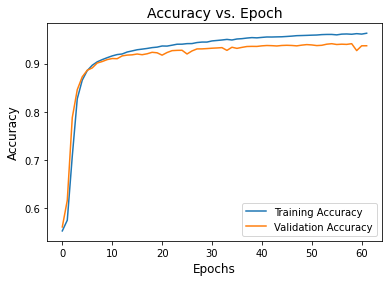

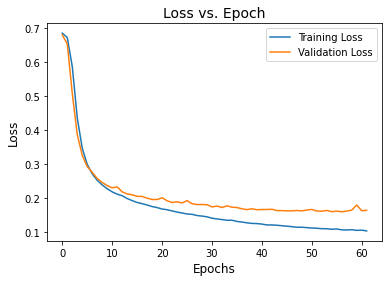

In [13]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 150

model = train(data_train, label_train, data_val, label_val, batch_size, lr, epochs)
model.save('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_tf/model')

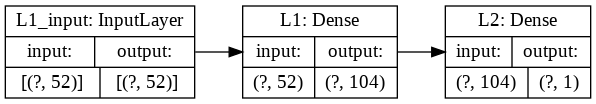

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   multiple                  5512      
_________________________________________________________________
L2 (Dense)                   multiple                  105       
Total params: 5,617
Trainable params: 5,617
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(len(model.layers[0].get_weights()[0][:,1])):
    print(i//13, i%13, model.layers[0].get_weights()[0][:,1][i])

0 0 -0.33944997
0 1 -0.6191158
0 2 0.37676212
0 3 -0.64644986
0 4 -0.3955076
0 5 -0.7629542
0 6 -1.4242308
0 7 2.7381973
0 8 -2.6731455
0 9 -0.3406369
0 10 -0.4208271
0 11 -0.14310859
0 12 -0.19401489
1 0 0.09169499
1 1 -0.1618409
1 2 -0.08204697
1 3 -0.84886193
1 4 -0.9843865
1 5 0.59416103
1 6 1.7329305
1 7 -6.699412
1 8 4.6122923
1 9 1.7792181
1 10 -0.2099912
1 11 -1.3469609
1 12 -0.06531084
2 0 -0.15095162
2 1 -0.17401893
2 2 -0.8754339
2 3 0.13514966
2 4 0.19205233
2 5 -1.2296538
2 6 -1.1681557
2 7 3.0802412
2 8 -2.3131366
2 9 -0.6134104
2 10 -0.1663517
2 11 0.4949422
2 12 -0.29898855
3 0 0.0009700733
3 1 0.091994934
3 2 -0.38097855
3 3 -0.035545815
3 4 0.14797075
3 5 -0.80082357
3 6 -1.287158
3 7 3.6412866
3 8 -2.2746677
3 9 -1.5365498
3 10 -0.16850159
3 11 0.9260892
3 12 -0.48217186


### Confusion Matrix

In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_tf/model')
classes = ["No Knock", "Knock"]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Train Set (Balanced)

Accuracy:  0.9733810928501194
Normalized confusion matrix
[[0.96014378 0.03985622]
 [0.01334529 0.98665471]]


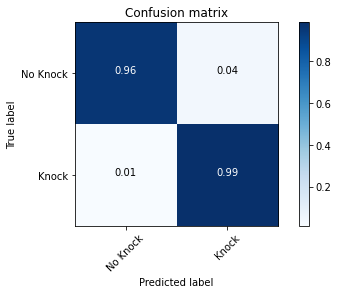

Confusion matrix, without normalization
[[54757  2273]
 [  759 56115]]


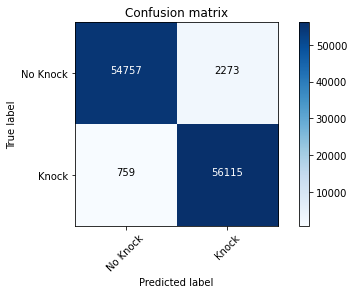

In [ ]:
plot_cm(classes, model, data_train, label_train)

#### Validation Set (Balanced)

Accuracy:  0.9528228449688627
Normalized confusion matrix
[[0.93444307 0.06555693]
 [0.02891448 0.97108552]]


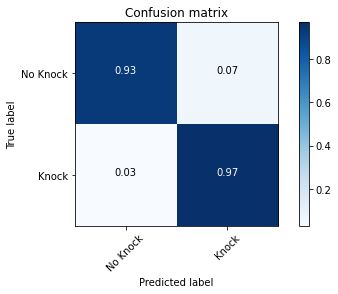

Confusion matrix, without normalization
[[22735  1595]
 [  708 23778]]


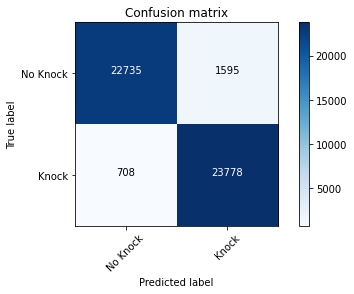

In [ ]:
plot_cm(classes, model, data_val, label_val)

#### Balanced Set

Accuracy:  0.9581981317600786
Normalized confusion matrix
[[0.93442724 0.06557276]
 [0.01803097 0.98196903]]


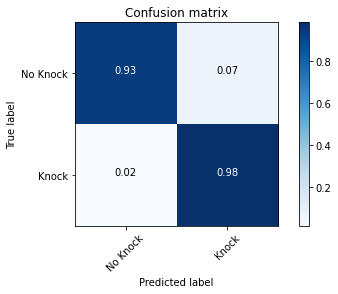

Confusion matrix, without normalization
[[76025  5335]
 [ 1467 79893]]


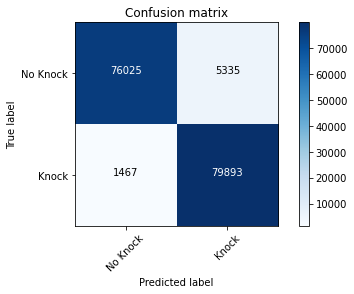

In [ ]:
plot_cm(classes, model, states_bal, labels_bal)

#### Entire Set

Accuracy:  0.9378916411948661
Normalized confusion matrix
[[0.93406875 0.06593125]
 [0.01803097 0.98196903]]


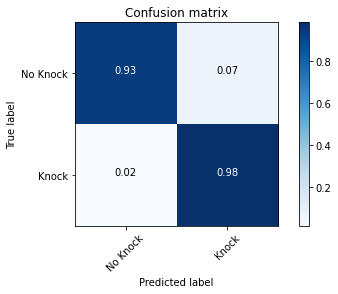

Confusion matrix, without normalization
[[876220  61848]
 [  1467  79893]]


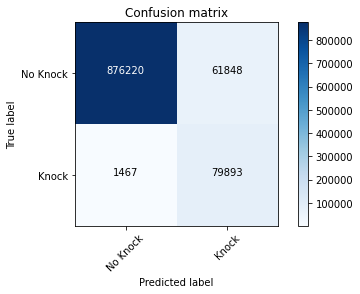

In [ ]:
plot_cm(classes, model, states, labels)

#### Test Set

Accuracy:  0.9378194375925012
Normalized confusion matrix
[[0.93398019 0.06601981]
 [0.01797708 0.98202292]]


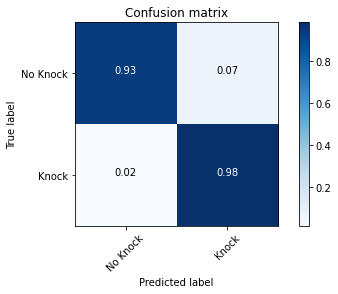

Confusion matrix, without normalization
[[217736  15391]
 [   364  19884]]


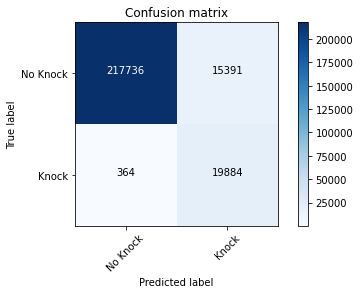

In [ ]:
states_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand2k.npy')
label_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock2k.npy')

plot_cm(classes, model, states_test, label_test)

## WinLoss Model

### Model

In [ ]:
def MLP(input_size, lr):
    # define MLP model
    model = Sequential()
    model.add(Dense(input_size*2, input_dim=input_size, name='L1', activation='sigmoid'))
    model.add(Dense(1, name='L2', activation='sigmoid'))

    # define loss function and optimizer and compile model
    loss_fnc = BinaryCrossentropy()
    optimizer = Adam(learning_rate=lr)
    tpClass = TruePositives()
    tnClass = TrueNegatives()
    fpClass = FalsePositives()
    fnClass = FalseNegatives()
    model.compile(loss=loss_fnc, optimizer=optimizer, metrics=[tpClass,tnClass,fpClass,fnClass])
    return model

### Training

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss8k.npy')

states_bal, labels_bal = balance(states, labels)
data_train, data_val, label_train, label_val = train_test_split(states_bal, labels_bal, test_size=0.3, random_state=421)

Training...
Training Complete


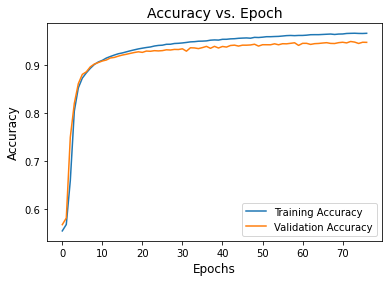

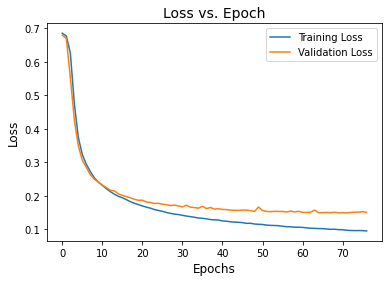

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 150

model = train(data_train, label_train, data_val, label_val, batch_size, lr, epochs)
model.save('/content/drive/My Drive/Colab Notebooks/Thesis/models/winloss_tf/model')

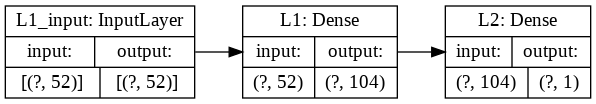

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   (None, 104)               5512      
_________________________________________________________________
L2 (Dense)                   (None, 1)                 105       
Total params: 5,617
Trainable params: 5,617
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].get_weights()

[array([[-0.8877904 ,  2.3897169 ,  1.9608256 , ...,  0.11676624,
          0.6715063 ,  0.5654955 ],
        [-0.44180492, -0.0613789 ,  1.648298  , ..., -0.04787655,
          1.9616107 ,  1.0479081 ],
        [-1.2556667 ,  0.8300794 ,  0.97268194, ...,  0.7215801 ,
          2.771841  ,  1.0192796 ],
        ...,
        [ 0.5824236 ,  1.4888142 ,  3.4603364 , ..., -1.4098446 ,
          5.1788964 ,  0.48103487],
        [-0.9879272 ,  0.60962445,  1.9023696 , ..., -1.777773  ,
          0.27275   ,  2.2127852 ],
        [ 0.18602528, -0.34834555,  2.2355888 , ...,  0.19754548,
         -0.04974943,  0.5846829 ]], dtype=float32),
 array([-0.358793  , -0.21224709,  0.4540687 ,  0.5012824 , -0.4169945 ,
        -0.53967375,  0.5126695 ,  0.08972139, -0.48077118, -0.19273633,
         0.13420033, -0.20002684, -0.30779532, -0.21310602, -0.38679808,
        -0.3259293 ,  0.26379192, -0.73557395,  0.00742557, -0.22166751,
        -0.3005435 , -0.45298848, -0.13301677, -0.4371228 ,  0.298

### Confusion Matrix

In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/models/winloss_tf/model')
classes = ["No Win", "Win"]

#### Train Set (Balanced)

Accuracy:  0.9703553504417796
Normalized confusion matrix
[[0.95806387 0.04193613]
 [0.01731363 0.98268637]]


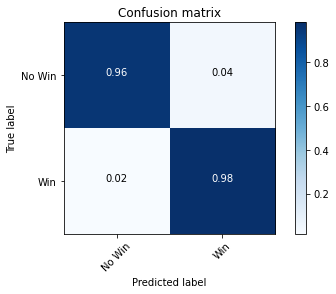

Confusion matrix, without normalization
[[52294  2289]
 [  942 53466]]


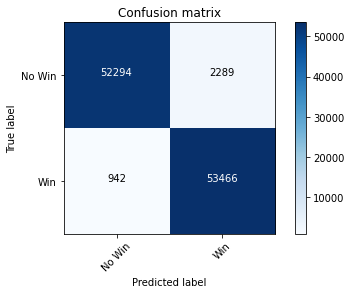

In [ ]:
plot_cm(classes, model, data_train, label_train)

#### Validation Set (Balanced)

Accuracy:  0.9478281347006059
Normalized confusion matrix
[[0.93200963 0.06799037]
 [0.03647144 0.96352856]]


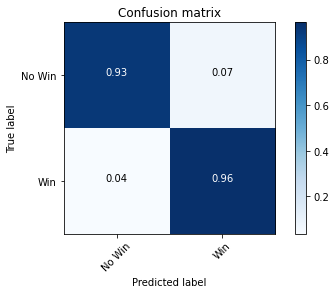

Confusion matrix, without normalization
[[21686  1582]
 [  855 22588]]


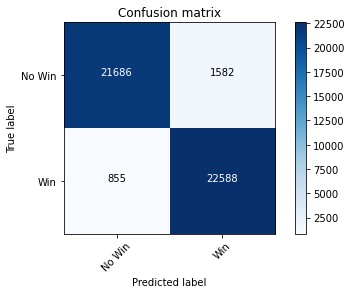

In [ ]:
plot_cm(classes, model, data_val, label_val)

#### Balanced Set

Accuracy:  0.9635971278467842
Normalized confusion matrix
[[0.95027681 0.04972319]
 [0.02308256 0.97691744]]


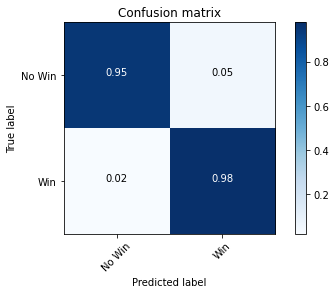

Confusion matrix, without normalization
[[73980  3871]
 [ 1797 76054]]


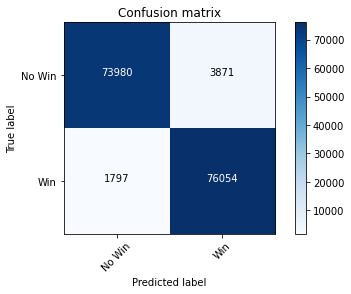

In [ ]:
plot_cm(classes, model, states_bal, labels_bal)

#### Entire Set

Accuracy:  0.9340944137300525
Normalized confusion matrix
[[0.93055374 0.06944626]
 [0.02308256 0.97691744]]


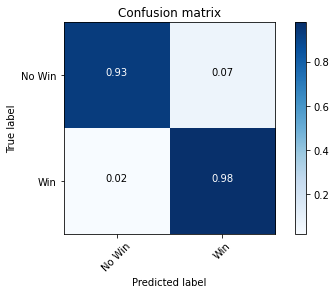

Confusion matrix, without normalization
[[876188  65389]
 [  1797  76054]]


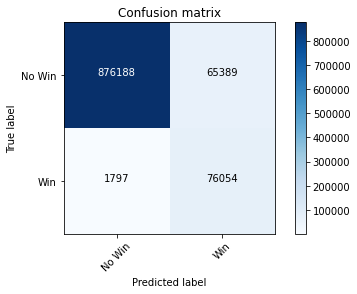

In [ ]:
plot_cm(classes, model, states, labels)

#### Test Set

Accuracy:  0.9342950172668969
Normalized confusion matrix
[[0.93076703 0.06923297]
 [0.02307931 0.97692069]]


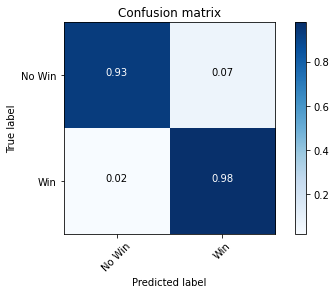

Confusion matrix, without normalization
[[217806  16201]
 [   447  18921]]


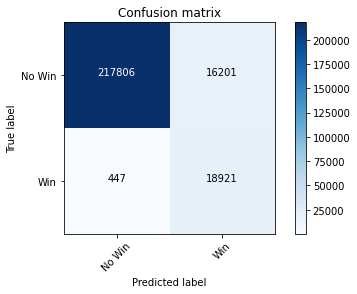

In [ ]:
states_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand2k.npy')
label_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/winloss2k.npy')

plot_cm(classes, model, states_test, label_test)

## Testing

In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_tf/model')

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import Card
%cd /content/drive/My Drive/Colab Notebooks/Thesis

In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_tf/model_og')
allCardsNames = 'AC 2C 3C 4C 5C 6C 7C 8C 9C TC JC QC KC AH 2H 3H 4H 5H 6H 7H 8H 9H TH JH QH KH AS 2S 3S 4S 5S 6S 7S 8S 9S TS JS QS KS AD 2D 3D 4D 5D 6D 7D 8D 9D TD JD QD KD'
allCardsNamesArr = allCardsNames.split(' ')
for i in range(len(model.layers[0].get_weights()[0][:,1])):
    print(allCardsNamesArr[i], model.layers[0].get_weights()[0][:,1][i])

In [42]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_tf/model_og')
allCardsNames = 'AC 2C 3C 4C 5C 6C 7C 8C 9C TC JC QC KC AH 2H 3H 4H 5H 6H 7H 8H 9H TH JH QH KH AS 2S 3S 4S 5S 6S 7S 8S 9S TS JS QS KS AD 2D 3D 4D 5D 6D 7D 8D 9D TD JD QD KD'
allCardsNamesArr = allCardsNames.split(' ')
w = model.layers[0].get_weights()[0][:,1]
ind = (-1*w).argsort()
for i in ind:
    print(allCardsNamesArr[i], np.around(w[i].item(),4))

9H 4.6123
8D 3.6413
8S 3.0802
8C 2.7382
TH 1.7792
7H 1.7329
QD 0.9261
6H 0.5942
QS 0.4949
3C 0.3768
5S 0.1921
5D 0.148
4S 0.1351
2D 0.092
AH 0.0917
AD 0.001
4D -0.0355
KH -0.0653
3H -0.082
QC -0.1431
AS -0.151
2H -0.1618
JS -0.1664
JD -0.1685
2S -0.174
KC -0.194
JH -0.21
KS -0.299
AC -0.3394
TC -0.3406
3D -0.381
5C -0.3955
JC -0.4208
KD -0.4822
TS -0.6134
2C -0.6191
4C -0.6464
6C -0.763
6D -0.8008
4H -0.8489
3S -0.8754
5H -0.9844
7S -1.1682
6S -1.2297
7D -1.2872
QH -1.347
7C -1.4242
TD -1.5365
9D -2.2747
9S -2.3131
9C -2.6731
8H -6.6994


In [33]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_tf/model')
w = model.layers[0].get_weights()[0][:,1]
ind = (-1*w).argsort()
for i in ind:
    print(Card.Card(i%13,i//13), np.around(w[i].item(),4))

JC 3.2313
9C 3.1405
9D 2.4974
KC 2.3504
6C 1.3327
7C 0.7886
3S 0.7594
9H 0.627
JD 0.5223
5C 0.5085
6H 0.4477
TC 0.4417
2S 0.3866
4H 0.3574
AC 0.3099
KD 0.1632
6D 0.083
4D -0.0026
AD -0.0297
5H -0.0967
AH -0.1354
5S -0.1726
3D -0.1893
9S -0.1939
3H -0.1949
3C -0.2775
2D -0.302
5D -0.3244
4S -0.367
2C -0.3733
6S -0.4217
8C -0.4415
2H -0.5017
4C -0.5628
TD -0.754
8D -0.7635
AS -0.8142
7D -1.0014
KS -1.0172
QD -1.2602
KH -1.2699
JH -1.577
JS -2.8506
QC -3.5596
7H -4.8606
QS -6.0091
7S -6.6009
TH -9.2978
8S -9.4097
TS -9.4935
QH -9.8016
8H -10.4345


In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_tf/model')

In [ ]:
model.get_weights()

In [ ]:
def one_hot(cards):
    ret = np.zeros(52)
    for card in cards:
        ret[card.getId()] = 1
    return ret

def un_one_hot(arr):
    rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
    suitNames = ["C", "H", "S", "D"]
    ret = []
    for i in range(len(arr)):
        if arr[i] != 0:
            ret.append(rankNames[i%13] + suitNames[i//13])
    return ret

In [16]:
%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import Card
%cd /content/drive/My Drive/Colab Notebooks/Thesis
# C -> H -> S -> D
# 0 -> 1 -> 2 -> 3

# A -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> J -> Q -> K
# 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12
# Card.Card(6, 0)

allCards = []
suit = 0
rank = 0
for s in range(Card.Card.NUM_SUITS):
    for r in range(Card.Card.NUM_RANKS):
        c = Card.Card(r, s)
        print(str(c) + ("\n" if r == Card.Card.NUM_RANKS - 1 else " "), end="")
        # print(str(c) + ("\n" if r == Card.Card.NUM_RANKS - 1 else "\t"), end="")
        # print(str(c) + ("\n" if r == Card.Card.NUM_RANKS - 1 else "\t\t"), end="")
        allCards += [c]
    rank = 1
    for r in range(Card.Card.NUM_RANKS):
        print(str(suit*13 + rank) + ("\n\n" if r == Card.Card.NUM_RANKS - 1 else " "), end="")
        # print(str(suit*13 + rank) + ("\n\n" if r == Card.Card.NUM_RANKS - 1 else "\t"), end="")
        # print(str(r)+ ', ' + str(s) + ("\n\n" if r == Card.Card.NUM_RANKS - 1 else "\t"), end="")
        rank += 1
    suit += 1

/content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
/content/drive/My Drive/Colab Notebooks/Thesis
AS 2S 3S 4S 5S 6S 7S 8S 9S TS JS QS KS
1 2 3 4 5 6 7 8 9 10 11 12 13

AH 2H 3H 4H 5H 6H 7H 8H 9H TH JH QH KH
14 15 16 17 18 19 20 21 22 23 24 25 26

AD 2D 3D 4D 5D 6D 7D 8D 9D TD JD QD KD
27 28 29 30 31 32 33 34 35 36 37 38 39

AC 2C 3C 4C 5C 6C 7C 8C 9C TC JC QC KC
40 41 42 43 44 45 46 47 48 49 50 51 52



In [ ]:
'''
AC	2C	3C	4C	5C	6C	7C	8C	9C	TC	JC	QC	KC
1	2	3	4	5	6	7	8	9	10	11	12	13

AH	2H	3H	4H	5H	6H	7H	8H	9H	TH	JH	QH	KH
14	15	16	17	18	19	20	21	22	23	24	25	26

AS	2S	3S	4S	5S	6S	7S	8S	9S	TS	JS	QS	KS
27	28	29	30	31	32	33	34	35	36	37	38	39

AD	2D	3D	4D	5D	6D	7D	8D	9D	TD	JD	QD	KD
40	41	42	43	44	45	46	47	48	49	50	51	52


        --------------------------------------        Number          ---------------------------------------
        A       2       3       4       5       6       7       8       9       T      J       Q       K

C       AC		2C		3C		4C		5C		6C		7C		8C		9C		TC		JC		QC		KC
        0, 0	1, 0	2, 0	3, 0	4, 0	5, 0	6, 0	7, 0	8, 0	9, 0	10, 0	11, 0	12, 0

H       AH		2H		3H		4H		5H		6H		7H		8H		9H		TH		JH		QH		KH
        0, 1	1, 1	2, 1	3, 1	4, 1	5, 1	6, 1	7, 1	8, 1	9, 1	10, 1	11, 1	12, 1

S       AS		2S		3S		4S		5S		6S		7S		8S		9S		TS		JS		QS		KS
        0, 2	1, 2	2, 2	3, 2	4, 2	5, 2	6, 2	7, 2	8, 2	9, 2	10, 2	11, 2	12, 2

D       AD		2D		3D		4D		5D		6D		7D		8D		9D		TD		JD		QD		KD
        0, 3	1, 3	2, 3	3, 3	4, 3	5, 3	6, 3	7, 3	8, 3	9, 3	10, 3	11, 3	12, 3

'''

# [[6S, 7S, 8S, 9S], [3C, 3H, 3D], 4C, AH, AC]


# (r, s)
# 
hand = [Card.Card(5, 2),
        Card.Card(6, 2),
        Card.Card(7, 2),
        Card.Card(8, 2),

        Card.Card(2, 0),
        Card.Card(2, 0),
        Card.Card(2, 0),

        Card.Card(3, 0),
        Card.Card(0, 0),
        Card.Card(0, 1)]

input = one_hot(hand)
input = np.expand_dims(input,axis=0)
# GinRummyUtil.getDeadwoodPoints3(input)
model.predict_proba(input).flatten()

array([0.99958843], dtype=float32)

### Function Definition

In [ ]:
allCardsNames = 'AC 2C 3C 4C 5C 6C 7C 8C 9C TC JC QC KC AH 2H 3H 4H 5H 6H 7H 8H 9H TH JH QH KH AS 2S 3S 4S 5S 6S 7S 8S 9S TS JS QS KS AD 2D 3D 4D 5D 6D 7D 8D 9D TD JD QD KD'
allCardsNamesArr = allCardsNames.split(' ')
allCards = []
for cardName in allCardsNamesArr:
    allCards.append(Deck.strCardMap[cardName])

def meldedHand(cards):
    unmeldedCards = cards.copy()
    bestMelds = GinRummyUtil.cardsToBestMeldSets(unmeldedCards)
    if len(bestMelds) == 0:
        melds = unmeldedCards
        deadwood = GinRummyUtil.getDeadwoodPoints3(unmeldedCards)
    else:
        melds = bestMelds[0]
        for meld in melds:
            # print(meld)
            for card in meld:
                # print(card)
                # print(unmeldedCards)
                unmeldedCards.remove(card)
        melds.extend(unmeldedCards)
        deadwood = GinRummyUtil.getDeadwoodPoints3(unmeldedCards)
    return melds, deadwood

def testHand(cards):
    meldSet, deadwood = meldedHand(cards)
    print("%s with %d deadwood." % (meldSet, deadwood))
    label = deadwood <= 10
    input = one_hot(cards)
    input = np.expand_dims(input,axis=0)
    prob = model.predict_proba(input).flatten()
    print('Predicted Output:', prob)
    guess = prob > 0.5
    if guess and label: # TN
        print('Correct! Model guessed knocked')
        return 'TN'
        # pass
    elif not guess and not label: # TP
        print('Correct! Model guessed NOT knocked')
        return 'TP'
        # pass
    elif guess and not label:   #FP
        # print("%s with %d deadwood." % (meldSet, deadwood))
        # print('Predicted Output:', prob)
        print('Incorrect! Model guessed knocked')
        print('\n\n')
        return 'FP'
    elif not guess and label: # FN
        # print("%s with %d deadwood." % (meldSet, deadwood))
        # print('Predicted Output:', prob)
        print('Incorrect! Model guessed NOT knocked')
        print('\n\n')
        return 'FN'

In [ ]:
cardNames = '[AS, AH, AC, 2C, 3C, 4C, 4H, 4D, 4S, 5C]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
testHand(hand)


[[2C, 3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D]] with 0 deadwood.
Predicted Output: [0.99999976]
Correct! Model guessed knocked


'TN'

### Random Hand (Not Knocked)

In [ ]:
cardNames = '[KC, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[AC, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 62 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[2C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 63 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[3C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 64 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[[4C, 4H, 4S], 7D, 2D, 9D, 7H, KH, TH, 8S] with 53 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[5C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 66 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[6C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 67 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[[7C, 7H, 7D], 2D, 9D, 4H, KH, TH, 8S, 4S] with 47 deadwood.
Predicted Output: [7.9020566e-08]
Correct! Model guessed NOT knocked
[8C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 69 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[9C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 70 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[ 1.  0.]
 [nan nan]]


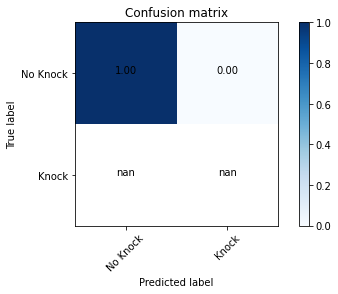

Confusion matrix, without normalization
[[430   0]
 [  0   0]]


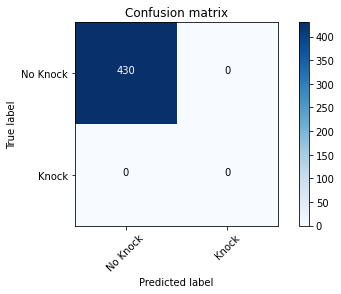

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

### Variations of Knocked Hand (GIN)

In [ ]:
cardNames = '[[2C, 3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D]]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[3C, 4C, 5C, 6C], [AC, AH, AS], [4H, 4S, 4D]] with 0 deadwood.
Predicted Output: [0.9997429]
Correct! Model guessed knocked
[[3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D], 7C] with 7 deadwood.
Predicted Output: [0.7174135]
Correct! Model guessed knocked
[[3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D], 8C] with 8 deadwood.
Predicted Output: [0.36068437]
Incorrect! Model guessed NOT knocked



[[3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D], 9C] with 9 deadwood.
Predicted Output: [0.99450016]
Correct! Model guessed knocked
[[3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D], TC] with 10 deadwood.
Predicted Output: [0.99956685]
Correct! Model guessed knocked
[[3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D], JC] with 10 deadwood.
Predicted Output: [0.99852484]
Correct! Model guessed knocked
[[3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D], QC] with 10 deadwood.
Predicted Output: [0.9999981]
Correct! Model guessed knocked
[[3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D], KC] with 10 deadwood.
Predicted Output: [0.9999877]
Correct! Model

Normalized confusion matrix
[[0.25112108 0.74887892]
 [0.06435644 0.93564356]]


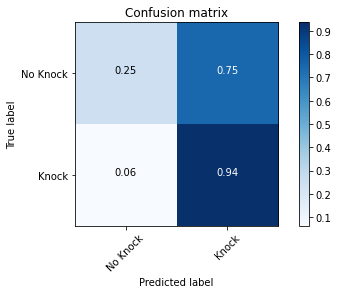

Confusion matrix, without normalization
[[ 56 167]
 [ 13 189]]


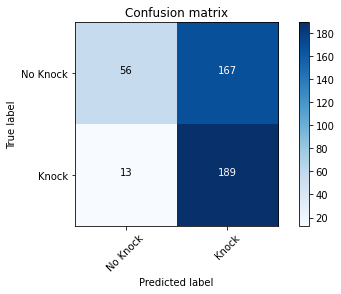

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 4 Deadwood (1 card))

In [ ]:
cardNames = '[[2C, 2H, 2D], [6C, 6H, 6D], [7H, 7S, 7D], 4D]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[6C, 6H, 6D], [7H, 7S, 7D], AC, 2H, 2D, 4D] with 9 deadwood.
Predicted Output: [0.9944841]
Correct! Model guessed knocked
[[2C, 2H, 2D], [6C, 6H, 6D], [7H, 7S, 7D], 4D] with 4 deadwood.
Predicted Output: [0.99029446]
Correct! Model guessed knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 3C, 2H, 2D, 4D] with 11 deadwood.
Predicted Output: [0.5775903]
Incorrect! Model guessed knocked



[[6C, 6H, 6D], [7H, 7S, 7D], 4C, 2H, 2D, 4D] with 12 deadwood.
Predicted Output: [0.3678317]
Correct! Model guessed NOT knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 5C, 2H, 2D, 4D] with 13 deadwood.
Predicted Output: [0.01166056]
Correct! Model guessed NOT knocked
[[6C, 6H, 6D], [7C, 7H, 7S, 7D], 2H, 2D, 4D] with 8 deadwood.
Predicted Output: [0.9999373]
Correct! Model guessed knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 8C, 2H, 2D, 4D] with 16 deadwood.
Predicted Output: [0.00512346]
Correct! Model guessed NOT knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 9C, 2H, 2D, 4D] with 17 deadwood.
Predicted Output: [0.12712461]
Correct! Model gues

Normalized confusion matrix
[[0.90201729 0.09798271]
 [0.02409639 0.97590361]]


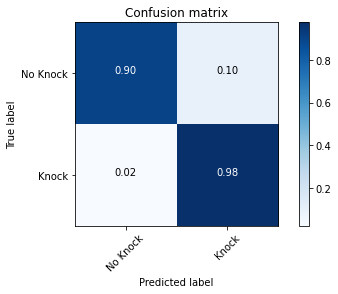

Confusion matrix, without normalization
[[313  34]
 [  2  81]]


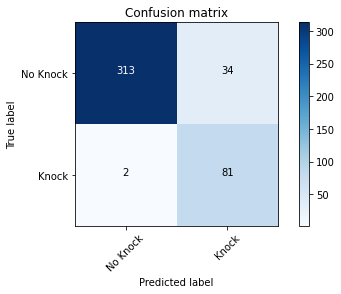

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 7 Deadwood (2 cards))

In [ ]:
cardNames = '[[3S, 4S, 5S], [4D, 5D, 6D, 7D, 8D], 6H, AC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[4D, 5D, 6D, 7D, 8D], 2C, 4S, 5S, 6H, AC] with 18 deadwood.
Predicted Output: [0.00554807]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 3C, 4S, 5S, 6H, AC] with 19 deadwood.
Predicted Output: [0.00057075]
Correct! Model guessed NOT knocked
[[5D, 6D, 7D, 8D], [4C, 4S, 4D], 5S, 6H, AC] with 12 deadwood.
Predicted Output: [0.0020127]
Correct! Model guessed NOT knocked
[[6D, 7D, 8D], [5C, 5S, 5D], 4S, 4D, 6H, AC] with 15 deadwood.
Predicted Output: [0.00260788]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 6C, 4S, 5S, 6H, AC] with 22 deadwood.
Predicted Output: [0.00043061]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 7C, 4S, 5S, 6H, AC] with 23 deadwood.
Predicted Output: [7.4356933e-07]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 8C, 4S, 5S, 6H, AC] with 24 deadwood.
Predicted Output: [0.00624716]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 9C, 4S, 5S, 6H, AC] with 25 deadwood.
Predicted Output: [0.00081185]
Correct! Mode

Normalized confusion matrix
[[0.92067989 0.07932011]
 [0.56578947 0.43421053]]


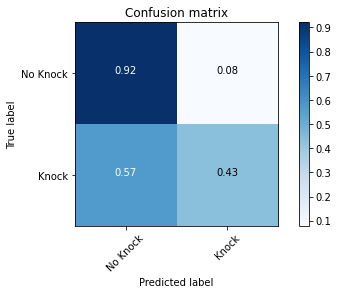

Confusion matrix, without normalization
[[325  28]
 [ 43  33]]


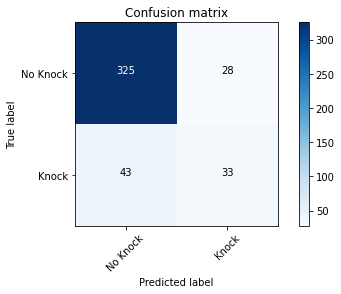

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 16 Deadwood (2 cards))

In [ ]:
cardNames = '[[3S, 4S, 5S], [4D, 5D, 6D, 7D, 8D], 6H, TC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
testHand(hand)
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[3S, 4S, 5S], [4D, 5D, 6D, 7D, 8D], 6H, TC] with 16 deadwood.
Predicted Output: [0.00194609]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], AC, 4S, 5S, 6H, TC] with 26 deadwood.
Predicted Output: [0.00040433]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 2C, 4S, 5S, 6H, TC] with 27 deadwood.
Predicted Output: [5.647294e-05]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 3C, 4S, 5S, 6H, TC] with 28 deadwood.
Predicted Output: [1.1442987e-06]
Correct! Model guessed NOT knocked
[[5D, 6D, 7D, 8D], [4C, 4S, 4D], 5S, 6H, TC] with 21 deadwood.
Predicted Output: [0.00023394]
Correct! Model guessed NOT knocked
[[6D, 7D, 8D], [5C, 5S, 5D], 4S, 4D, 6H, TC] with 24 deadwood.
Predicted Output: [0.00016125]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 6C, 4S, 5S, 6H, TC] with 31 deadwood.
Predicted Output: [6.4981414e-06]
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 7C, 4S, 5S, 6H, TC] with 32 deadwood.
Predicted Output: [1.6055371e-07]
Co

Normalized confusion matrix
[[0.92457421 0.07542579]
 [0.63157895 0.36842105]]


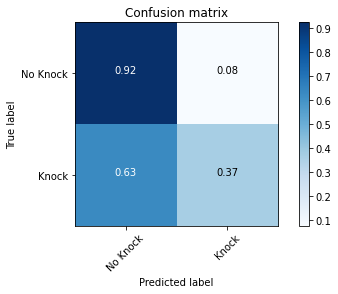

Confusion matrix, without normalization
[[380  31]
 [ 12   7]]


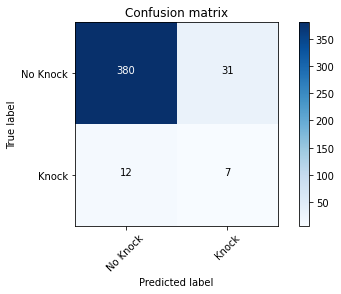

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 6 Deadwood (3 cards))

In [ ]:
cardNames = '[[6S, 7S, 8S, 9S], [3C, 3H, 3D], 4C, AH, AC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[AC, 2C, 3C, 4C], [7S, 8S, 9S], 3H, 3D, AH] with 7 deadwood.
Predicted Output: [0.9997551]
Correct! Model guessed knocked
[[3C, 4C, 5C], [7S, 8S, 9S], 3H, 3D, AH, AC] with 8 deadwood.
Predicted Output: [0.9997608]
Correct! Model guessed knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 6C, 4C, AH, AC] with 12 deadwood.
Predicted Output: [0.12306318]
Correct! Model guessed NOT knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 7C, 4C, AH, AC] with 13 deadwood.
Predicted Output: [0.00944679]
Correct! Model guessed NOT knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 8C, 4C, AH, AC] with 14 deadwood.
Predicted Output: [0.00828368]
Correct! Model guessed NOT knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 9C, 4C, AH, AC] with 15 deadwood.
Predicted Output: [0.20707451]
Correct! Model guessed NOT knocked
[[7S, 8S, 9S], [3C, 3H, 3D], TC, 4C, AH, AC] with 16 deadwood.
Predicted Output: [0.6843141]
Incorrect! Model guessed knocked



[[7S, 8S, 9S], [3C, 3H, 3D], JC, 4C, AH, AC] with 16 deadwood.
Predicted Output: [0.5688939]
Incorrect! Model

Normalized confusion matrix
[[0.6116208  0.3883792 ]
 [0.07843137 0.92156863]]


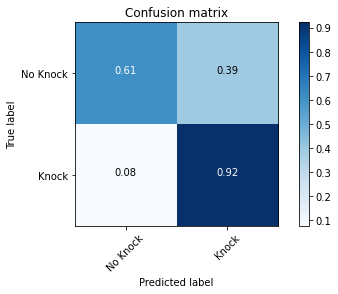

Confusion matrix, without normalization
[[200 127]
 [  8  94]]


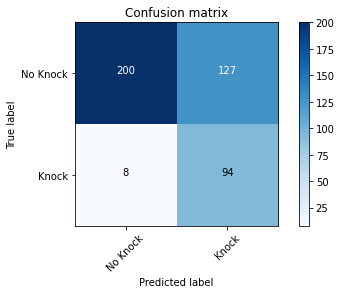

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 11 Deadwood (4 cards))


In [ ]:
cardNames = '[[8C, 8H, 8D], [JC, JH, JS], 5S, 4H, AD, AC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
# testHand(hand)
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[JC, JH, JS], 2C, 8H, 8D, 5S, 4H, AD, AC] with 29 deadwood.
Predicted Output: [1.6987228e-06]
Correct! Model guessed NOT knocked
[[JC, JH, JS], 3C, 8H, 8D, 5S, 4H, AD, AC] with 30 deadwood.
Predicted Output: [2.375414e-05]
Correct! Model guessed NOT knocked
[[JC, JH, JS], 4C, 8H, 8D, 5S, 4H, AD, AC] with 31 deadwood.
Predicted Output: [2.4826508e-05]
Correct! Model guessed NOT knocked
[[JC, JH, JS], 5C, 8H, 8D, 5S, 4H, AD, AC] with 32 deadwood.
Predicted Output: [2.6740824e-07]
Correct! Model guessed NOT knocked
[[JC, JH, JS], 6C, 8H, 8D, 5S, 4H, AD, AC] with 33 deadwood.
Predicted Output: [0.]
Correct! Model guessed NOT knocked
[[JC, JH, JS], 7C, 8H, 8D, 5S, 4H, AD, AC] with 34 deadwood.
Predicted Output: [2.9222868e-08]
Correct! Model guessed NOT knocked
[[8C, 8H, 8D], [JC, JH, JS], 5S, 4H, AD, AC] with 11 deadwood.
Predicted Output: [0.01609844]
Correct! Model guessed NOT knocked
[[JC, JH, JS], 9C, 8H, 8D, 5S, 4H, AD, AC] with 36 deadwood.
Predicted Output: [4.3432587e-07]
Correct!

Normalized confusion matrix
[[0.93718593 0.06281407]
 [0.12903226 0.87096774]]


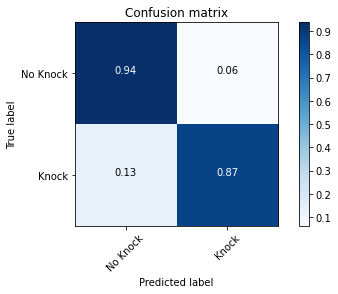

Confusion matrix, without normalization
[[373  25]
 [  4  27]]


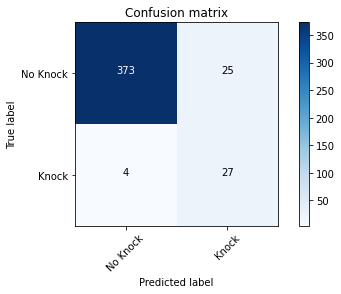

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix(cm, classes,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

# DQN

In [ ]:
!pip install rlcard
!pip install rlcard[tensorflow]
%cd /content/drive/My Drive/Colab Notebooks/Thesis

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


########## Evaluation 0 ##########
Timestep: 136 Average reward is -0.4365999999999998, reward2 is -0.5331999999999998

----------------------------------------
  timestep     |  136
  reward       |  -0.46999999999999986
----------------------------------------
INFO - Agent dqn, step 1000, rl-loss: 0.9186378121376038
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 2000, rl-loss: 0.3140160143375397
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 3000, rl-loss: 0.15907180309295654
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 4000, rl-loss: 0.1511426866054535
INFO - Copie

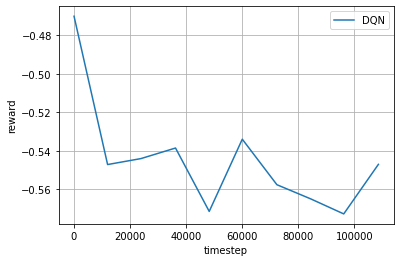

In [ ]:
import tensorflow as tf
import os

import rlcard

from rlcard.agents import DQNAgent
from rlcard.agents import RandomAgent
from rlcard.utils import set_global_seed, tournament
from rlcard.utils import Logger

# Make environment
env = rlcard.make('gin-rummy', config={'seed': 0})
eval_env = rlcard.make('gin-rummy', config={'seed': 0})
env.game.settings.print_settings()

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 1000  # mahjong_dqn has 100000

# The initial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

# The paths for saving the logs and learning curves
log_dir = './experiments/gin_rummy_dqn_result/'

# Set a global seed
set_global_seed(0)

with tf.Session() as sess:
    # Set agents
    global_step = tf.Variable(0, name='global_step', trainable=False)
    agent = DQNAgent(sess,
                     scope='dqn',
                     action_num=env.action_num,
                     replay_memory_size=20000,
                     replay_memory_init_size=memory_init_size,
                     train_every=train_every,
                     state_shape=env.state_shape,
                     mlp_layers=[52*2])

    random_agent = RandomAgent(action_num=eval_env.action_num)

    sess.run(tf.global_variables_initializer())

    env.set_agents([agent, random_agent])
    eval_env.set_agents([agent, random_agent])

    # Init a Logger to plot the learning curve
    logger = Logger(log_dir)

    for episode in range(episode_num):

        # Generate data from the environment
        trajectories, _ = env.run(is_training=True)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:
            agent.feed(ts)

        # extra logging
        if episode % evaluate_every == 0:
            reward = 0
            reward2 = 0
            for eval_episode in range(evaluate_num):
                _, payoffs = eval_env.run(is_training=False)
                reward += payoffs[0]
                reward2 += payoffs[1]
            logger.log("\n\n########## Evaluation {} ##########".format(episode))
            reward_text = "{}".format(float(reward)/evaluate_num)
            reward2_text = "{}".format(float(reward2)/evaluate_num)
            info = "Timestep: {} Average reward is {}, reward2 is {}".format(env.timestep, reward_text, reward2_text)
            logger.log(info)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

    # Close files in the logger
    logger.close_files()

    # Plot the learning curve
    logger.plot('DQN')

    # Save model
    save_dir = 'models/gin_rummy_dqn'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(save_dir, 'model'))


In [ ]:
clear_session()
agent = DQNAgent(sess,
                scope='dqn',
                action_num=env.action_num,
                replay_memory_size=20000,
                replay_memory_init_size=memory_init_size,
                train_every=train_every,
                state_shape=env.state_shape,
                mlp_layers=[512, 512])